In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel, convolve, convolve_fft
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import copy
from scipy import fft
from scipy.signal import butter, lfilter
from juanfit import SpectrumFitSingle

In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_3s_proto.h5", 'r') as hf:
    bias_dc_red_3s = hf['image'][:]

In [3]:
def calculate_flatfield_curve(filename,start_pixel,end_pixel,wvl_array=None,fit_order=5,plot_fit=False):
    with h5py.File(filename, 'r') as hf:
        flatfield_image = hf['image'][:]

    if wvl_array is None:
        wvl_array = np.arange(1392)
    flatfield_curve_tofit = np.mean(flatfield_image[start_pixel:end_pixel,:],axis=0)

    poly_param = np.polyfit(wvl_array,flatfield_curve_tofit,fit_order)
    poly_func = np.poly1d(poly_param)
    flatfield_curve_fit = poly_func(wvl_array)

    if plot_fit is True:
        fig, ax = plt.subplots(figsize=(18,6))
        ax.step(wvl_array,flatfield_curve_tofit,where="mid")
        ax.plot(wvl_array,flatfield_curve_fit,label="{:.0f}th order".format(fit_order),lw=2)

    return flatfield_curve_fit



array([0.79353022, 0.79397512, 0.79442867, ..., 0.84837267, 0.8449284 ,
       0.84147636])

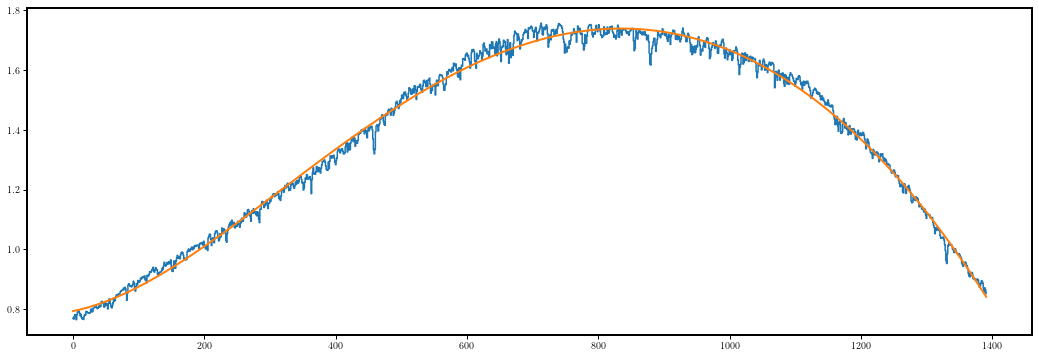

In [4]:
flatfield_fname = "../../sav/Eclipse/FlatField/skyflat_red_5s_norm_proto.h5"
calculate_flatfield_curve(flatfield_fname, 500,510,plot_fit=True)

In [6]:
data_example_fname = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/TotalitySequenceRed_7720.fit"
with fits.open(data_example_fname) as hdul:
    totality_image = np.copy(hdul[0].data)
    data_texp = np.copy(hdul[0].header["EXPTIME"])

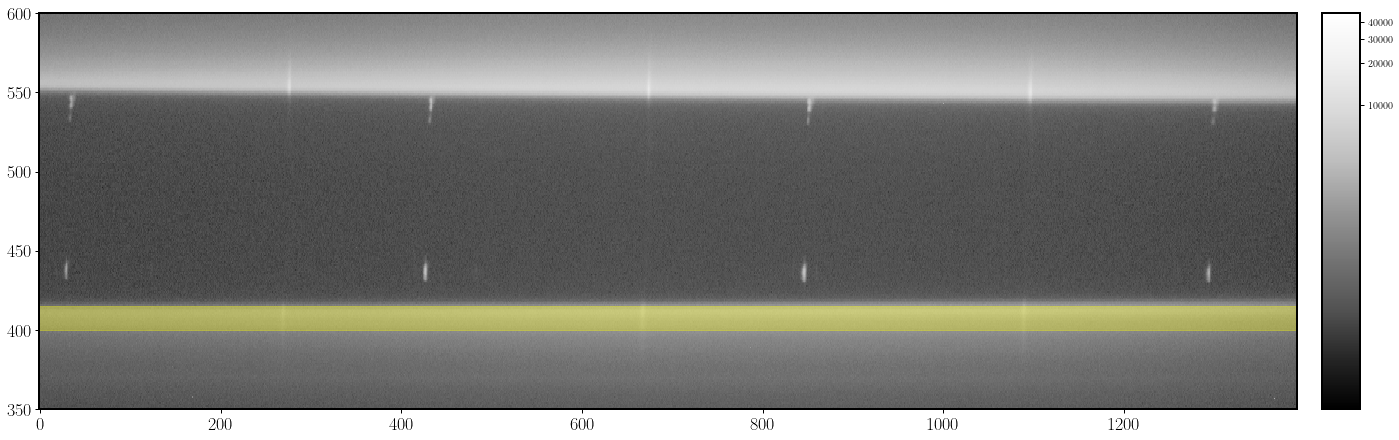

In [22]:
start_pixel, end_pixel = 400, 416
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
norm = ImageNormalize(totality_image,stretch=LogStretch())
im = ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image, norm=norm,
                cmap="Greys_r",rasterized=True)
ax.set_ylim(350,600)
clb_ax = inset_axes(ax,width="3%",height= "100%",loc='lower left',
        bbox_to_anchor=(1.02, 0., 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
ax.axhspan(start_pixel,end_pixel - 1,color="yellow",alpha=0.3)
ax.tick_params(labelsize=18)


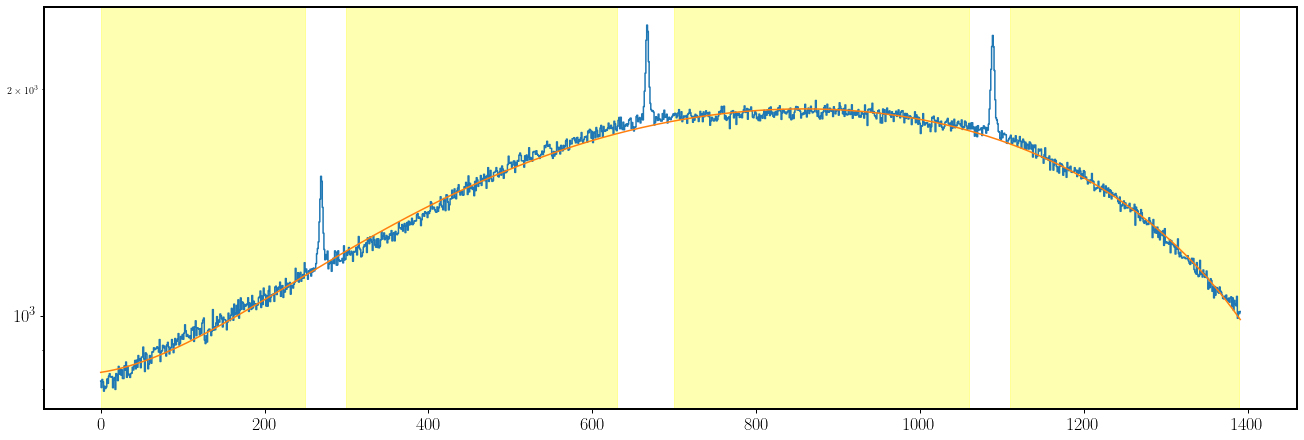

In [27]:
spectra_example = np.mean((totality_image - bias_dc_red_3s)[start_pixel:end_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
wvl_array = np.arange(1392)
ax.step(wvl_array, spectra_example,where="mid")
ax.set_yscale("log")
ax.tick_params(labelsize=18)

fit_intervals = [slice(0,250),slice(300,630),slice(700,1060),slice(1110,1390)]
for fit_interval in fit_intervals:
    ax.axvspan(fit_interval.start,fit_interval.stop,color="yellow",alpha=0.3)

background_poly_order = 5
wvl_array_to_fit = np.concatenate([wvl_array[fit_interval] for fit_interval in fit_intervals])
spectra_to_fit = np.concatenate([spectra_example[fit_interval] for fit_interval in fit_intervals])
background_poly_params = np.polyfit(wvl_array_to_fit,spectra_to_fit,background_poly_order)
background_poly_func = np.poly1d(background_poly_params)
background_poly_curve = background_poly_func(wvl_array)

ax.plot(wvl_array, background_poly_curve, label="{:.0f}th".format(background_poly_order))

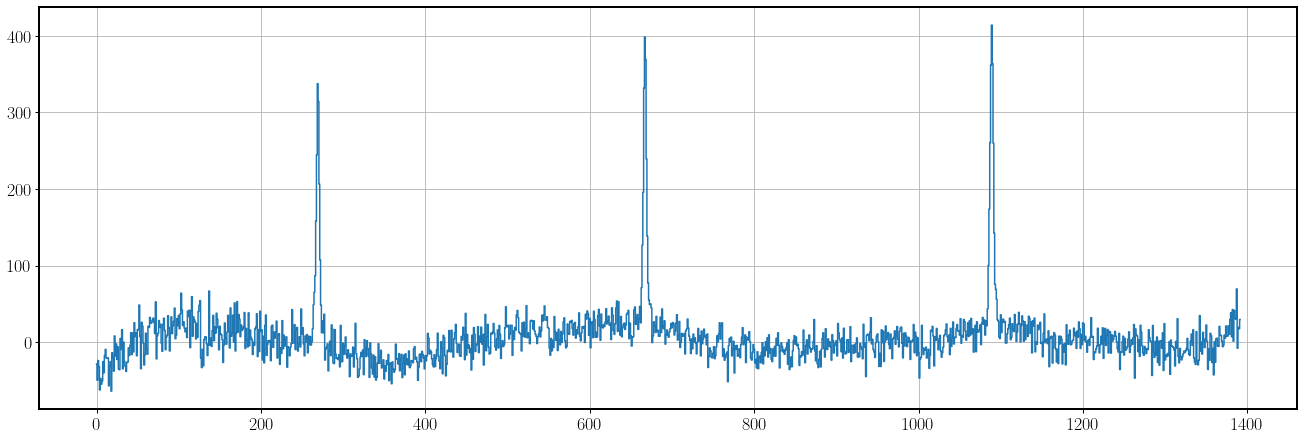

In [28]:
spectra_no_background = spectra_example - background_poly_curve
flatfield_curve = calculate_flatfield_curve(flatfield_fname,start_pixel=start_pixel, end_pixel=end_pixel)
spectra_flatfield = spectra_no_background/flatfield_curve/data_texp
spectra_err = np.sqrt(np.sum((totality_image - bias_dc_red_3s)[start_pixel:end_pixel,:],axis=0))/(end_pixel - start_pixel)/data_texp/flatfield_curve
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
ax.step(wvl_array, spectra_flatfield, where="mid")
ax.tick_params(labelsize=18)
ax.grid("on")

<AxesSubplot:ylabel='Intensity'>

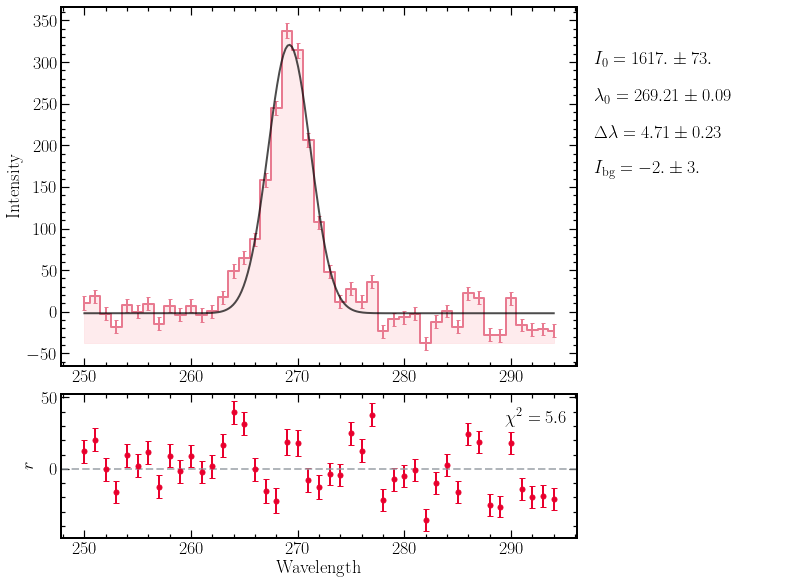

In [38]:
first_order_slice = slice(250,295)
first_order_model = SpectrumFitSingle(data=spectra_flatfield[first_order_slice], wvl=wvl_array[first_order_slice],
                    err=spectra_err[first_order_slice],line_number=1,line_wvl_init=[265],
                    int_max_init=[300],fwhm_init=[3],same_width=False)
first_order_model.run_lse(absolute_sigma=False)
first_order_model.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

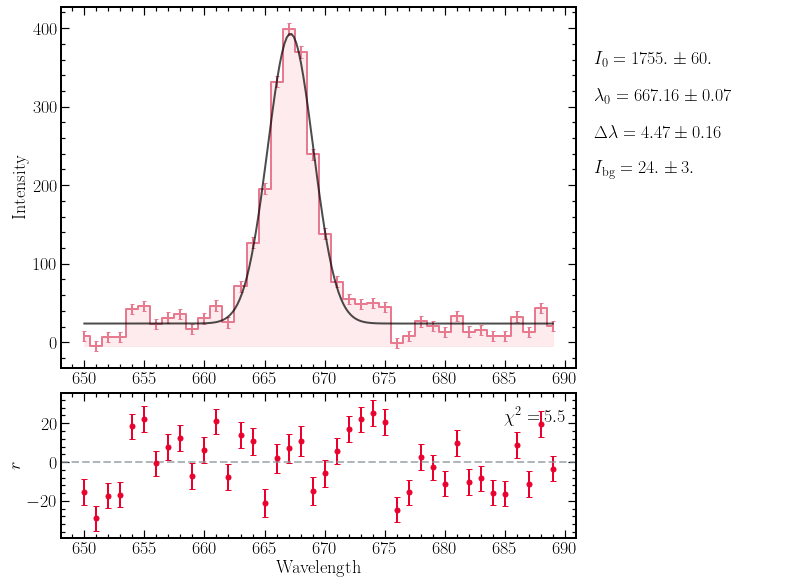

In [39]:
second_order_slice = slice(650,690)
second_order_model = SpectrumFitSingle(data=spectra_flatfield[second_order_slice], wvl=wvl_array[second_order_slice],
                    err=spectra_err[second_order_slice],line_number=1,line_wvl_init=[667],
                    int_max_init=[400],fwhm_init=[3],same_width=False)
second_order_model.run_lse(absolute_sigma=False)
second_order_model.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

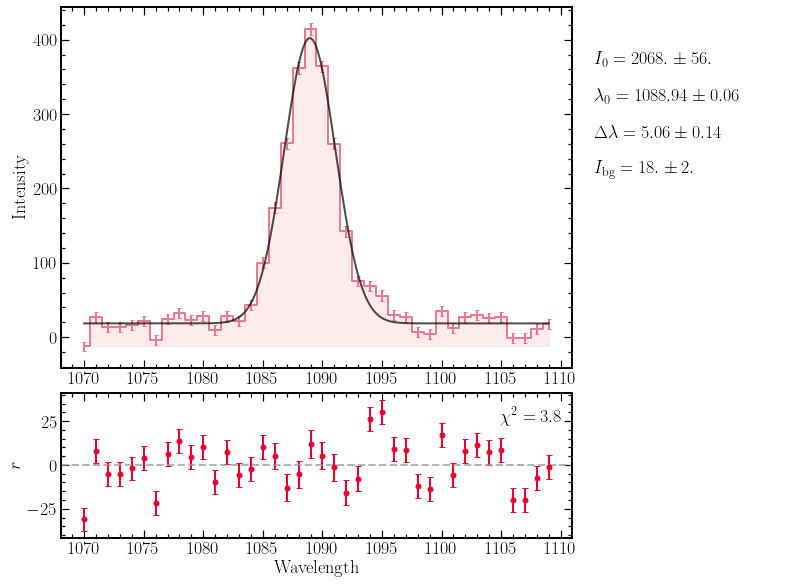

In [43]:
third_order_slice = slice(1070,1110)
third_order_model = SpectrumFitSingle(data=spectra_flatfield[third_order_slice], wvl=wvl_array[third_order_slice],
                    err=spectra_err[third_order_slice],line_number=1,line_wvl_init=[1090],
                    int_max_init=[400],fwhm_init=[3],same_width=False)
third_order_model.run_lse(absolute_sigma=False)
third_order_model.plot(plot_fit=True)